In [1]:
from numpy import arctan, array, random
from scipy.stats import linregress, sem
import matplotlib.pyplot as plt
from matplotlib import animation
from tqdm import tqdm

In [2]:
def simulate(gene_count, rate, gens, num_loops):

    # initialize genes
    genes = []
    for gene in range(gene_count):
        allele_1 = chr(gene + 65) # begin with capital A
        allele_2 = chr(gene + 97) # then lower case a
        genes.append(allele_1 + allele_2) # Aa

    sim_info = []
    prog_num = 0
    pbar = tqdm(total = num_loops * 11 * gens)
    for itera in range(num_loops):
        for simulation in range(11):

            prob = simulation/10
            gen_info = [] # include info of every generation
            info = [0, 0, 0, 0] # [population, homozygous, heterozygous, death]

            for gen in range(gens):

                info = [0, 0, 0, info[3]]

                if gen == 0:
                    # people = [genes, generation, death probability]
                    people = [[genes, 1, 0], [genes, 1, 0]] # create an inital population of 2 heterozygous people #### IMPORTANT SECTION
                    against = [] # determine natural selection against alleles

                for gene in genes:

                    for i, select in enumerate(against):
                        select[2] = int(select[2]) - 1
                        if select[2] == '0':
                            against.pop(i)

                    if random.random() > 1 - prob: # 1-n chance of natural selection
                        # against = [gene, how much against, number of generations]
                        val = random.random()
                        if random.randint(2) == 0:
                            against.append(array([gene[0], val, random.randint(5)], dtype=str))
                        else:
                            against.append(array([gene[1], val, random.randint(5)], dtype=str))

                # check alleles and increase chances of death when matched
                for i, person in enumerate(people):

                    person[1] += 1 # increase generation by 1
                    mort_age = 0.354 * arctan(person[1] - 3.5) + .44 # death probability from age #### IMPORTANT SECTION
                    mort_nature = 0
                    for pheno in person[0]:
                        for anti in against:

                            if ord(pheno[0]) >= 97 and ord(pheno[1]) >= 97: # if gene is monozygous recessive
                                if anti[0] in pheno:
                                    mort_nature += float(anti[1]) # add anti values to death probability

                            elif ord(pheno[0]) < 97 and ord(pheno[1]) < 97: # if gene is monozygous dominant
                                if anti[0] in pheno:
                                    mort_nature += float(anti[1])

                            elif ord(pheno[0]) < ord(pheno[1]): #Aa
                                if pheno[0] == anti[0]:
                                    mort_nature += float(anti[1])

                            elif ord(pheno[1]) < ord(pheno[0]): #aA
                                if pheno[1] == anti[0]:
                                    mort_nature += float(anti[1])

                    person[2] = (1/gene_count) * mort_nature + (1) * mort_age # ratio death factors #### IMPORTANT SECTION

                    if person[2] > random.random() and gen != 0: #don't kill Adam and Eve immediately
                        people.pop(i) # person killed by Darwin
                        info[3] += 1

                #birth loop
                for i in range(0, round(len(people)/2), 2):
                    for j in range(rate): # each couple has {rate} children
                        select_genes = []
                        for k in range(len(genes)):

                            allele_1 = people[i][0][k] # Aa
                            allele_2 = people[i+1][0][k] # Aa
                            punnett = []
                            punnett.append(allele_1[0] + allele_2[0]) # AA
                            punnett.append(allele_1[0] + allele_2[1]) # Aa
                            punnett.append(allele_1[1] + allele_2[0]) # aA
                            punnett.append(allele_1[1] + allele_2[1]) # aa
                            select_genes.append(random.choice(punnett)) # simulate punnett probability

                        people.append([select_genes, 1, 0]) # IT'S A BABY!!!

                info[0] = len(people) # record population of people

                # calculate heterozygous/ homozygous distributions
                total_genes = []
                for person in people: # print gene distribution
                    for gene in person[0]:

                        if ord(gene[0]) > ord(gene[1]): # check if heterozygous
                            a = gene[1]
                            b = gene[0]
                            gene = a + b # combine aA with Aa

                        total_genes.append(gene)

                for gene in total_genes:
                    if gene[0] == gene[1]:
                        info[1] += 1 # increase homozygous count
                    else:
                        info[2] += 1 # heterozygous

                gen_info.append(info)

                # update progress bar
                pbar.update(1)

            if len(people) > 0:
                sim_info.append(gen_info)
            else:
                return
    
    pbar.close()

    # Analyze population simulation
    x = []
    y = []
    for probability, ratio in enumerate(sim_info):
        x.append(10 * (probability % 11))
        y.append([100 * ratio[-1][2] / (ratio[-1][1] + ratio[-1][2])])

    # Statistically verify the trend
    # average all the values in the scatterplot
    t = [[] for i in range(11)]

    for i, data in enumerate(sim_info):
        t[i % 11] += [100 * data[-1][2] / (data[-1][1] + data[-1][2])]

    avgs = []
    e = []
    for avg in t:
        avgs.append(sum(avg) / len(avg))
        e.append(sem(avg)) # error bars

    return [avgs, e, sim_info]


def plot(y, e):
    x = range(0, 101, 10)
    bl = linregress(x, y)

    if abs(bl[2]) >= 0.1 and abs(bl[2]) < .3:
        r_lab = "Small "
    elif abs(bl[2]) >= 0.3 and abs(bl[2]) < .5:
        r_lab = "Medium "
    elif abs(bl[2]) >= 0.5:
        r_lab = "Large "
    else:
        r_lab = "No "
    
    plt.title("Correlation of Averaged Scatter Plot")
    plt.errorbar(x, y, e, color="blue", ecolor="lightgray", elinewidth=3)
    plt.plot(x, bl[0] * x + bl[1], color="red")
    plt.legend([r_lab+"Correlation = {}".format(round(bl[2], 1)), "Averaged Scatter Plot"])
    plt.xlabel("Probability of Natural Selection (%)")
    plt.ylabel("Percent Heterozygous (%)")
    # draw_figure(plt) #### 3
    plt.show()

In [3]:
gene_count = 3
rate = 5
gens = 15
num_loops = 100

100%|██████████| 16500/16500 [07:59<00:00, 34.42it/s]


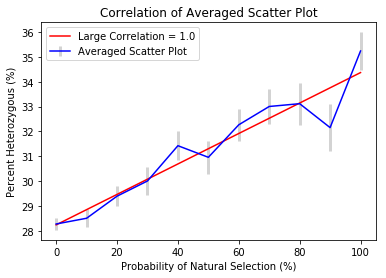

In [4]:
vals = simulate(gene_count, rate, gens, num_loops)
plot(vals[0], vals[1])

In [5]:
t = [[[], []] for i in range(11)]

for i, data in enumerate(vals[2]):
    # t[generation][hom_avg, het_avg]
    t[i % 11][0] += [data[-1][1]]
    t[i % 11][1] += [data[-1][2]]

In [6]:
avgs = [[], []]
e = [[], []]
for avg in t:
    avgs[0].append(sum(avg[0]) / len(avg[0]))
    avgs[1].append(sum(avg[1]) / len(avg[1]))
    e[0].append(sem(avg[0]))
    e[1].append(sem(avg[1])) # error bars

Heterozygous: 34%
Homozygous: 66%

Heterozygous: 32%
Homozygous: 68%

Heterozygous: 32%
Homozygous: 68%

Heterozygous: 32%
Homozygous: 68%

Heterozygous: 32%
Homozygous: 68%

Heterozygous: 30%
Homozygous: 70%

Heterozygous: 31%
Homozygous: 69%

Heterozygous: 30%
Homozygous: 70%

Heterozygous: 30%
Homozygous: 70%

Heterozygous: 28%
Homozygous: 72%

Heterozygous: 28%
Homozygous: 72%



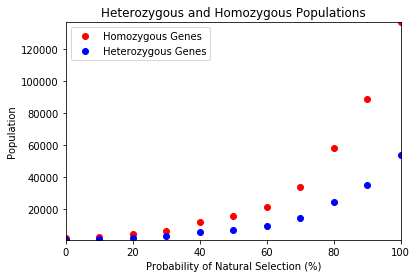

In [8]:
for i in range(len(avgs[0])):
    plt.title("Heterozygous and Homozygous Populations")
    plt.xlim(0, 100)
    plt.ylim(min(avgs[1]), max(avgs[0]))
    plt.xlabel("Probability of Natural Selection (%)")
    plt.ylabel("Population")
    plt.plot(10*i, avgs[0][10-i], 'ro')
    plt.plot(10*i, avgs[1][10-i], 'bo')
    plt.legend(["Homozygous Genes", "Heterozygous Genes"], loc="upper left")
    print(f"Heterozygous: {round(100*avgs[1][10-i]/(avgs[0][10-i]+avgs[1][10-i]))}%\nHomozygous: {round(100*avgs[0][10-i]/(avgs[0][10-i]+avgs[1][10-i]))}%\n")
    plt.savefig("ims/plt_"+str(i)+".png")